<>:152: SyntaxWarning: invalid escape sequence '\l'
<>:152: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_6902/124471067.py:152: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title(f"$\lambda = {lam:.2e}$", fontsize=14)
/tmp/ipykernel_6902/124471067.py:59: RuntimeWarning: divide by zero encountered in log
  p_hat_mle_np = np.log(num / (m - num).clip(min=1e-9)).clip(-10, 10)


Using device: cuda
1. Generating synthetic data...
   -> Generated 1000 SNVs across 4 true clusters.
2. Preparing initial data dictionary for the solver...
   -> Data preparation complete.

3. Calling `solve_coreset_path` API...
Validating inputs...
Input validation successful.
--- Starting Warm-Start ADMM Path for 16 Lambda values ---

Processing Path (Step 1/16): Lambda = 0.00e+00
Setting up Coreset Problem...
  -> Entering generic ADMM core (Lambda=0.00e+00)...
  -> ADMM core finished after 1 iterations.

Processing Path (Step 2/16): Lambda = 1.00e-04
Setting up Coreset Problem...
  -> Entering generic ADMM core (Lambda=1.00e-04)...
  -> ADMM core finished after 1 iterations.

Processing Path (Step 3/16): Lambda = 5.00e-04
Setting up Coreset Problem...
  -> Entering generic ADMM core (Lambda=5.00e-04)...
    Iter: 20, Residual: 0.000331
  -> ADMM core finished after 28 iterations.

Processing Path (Step 4/16): Lambda = 1.00e-03
Setting up Coreset Problem...
  -> Entering generic ADM

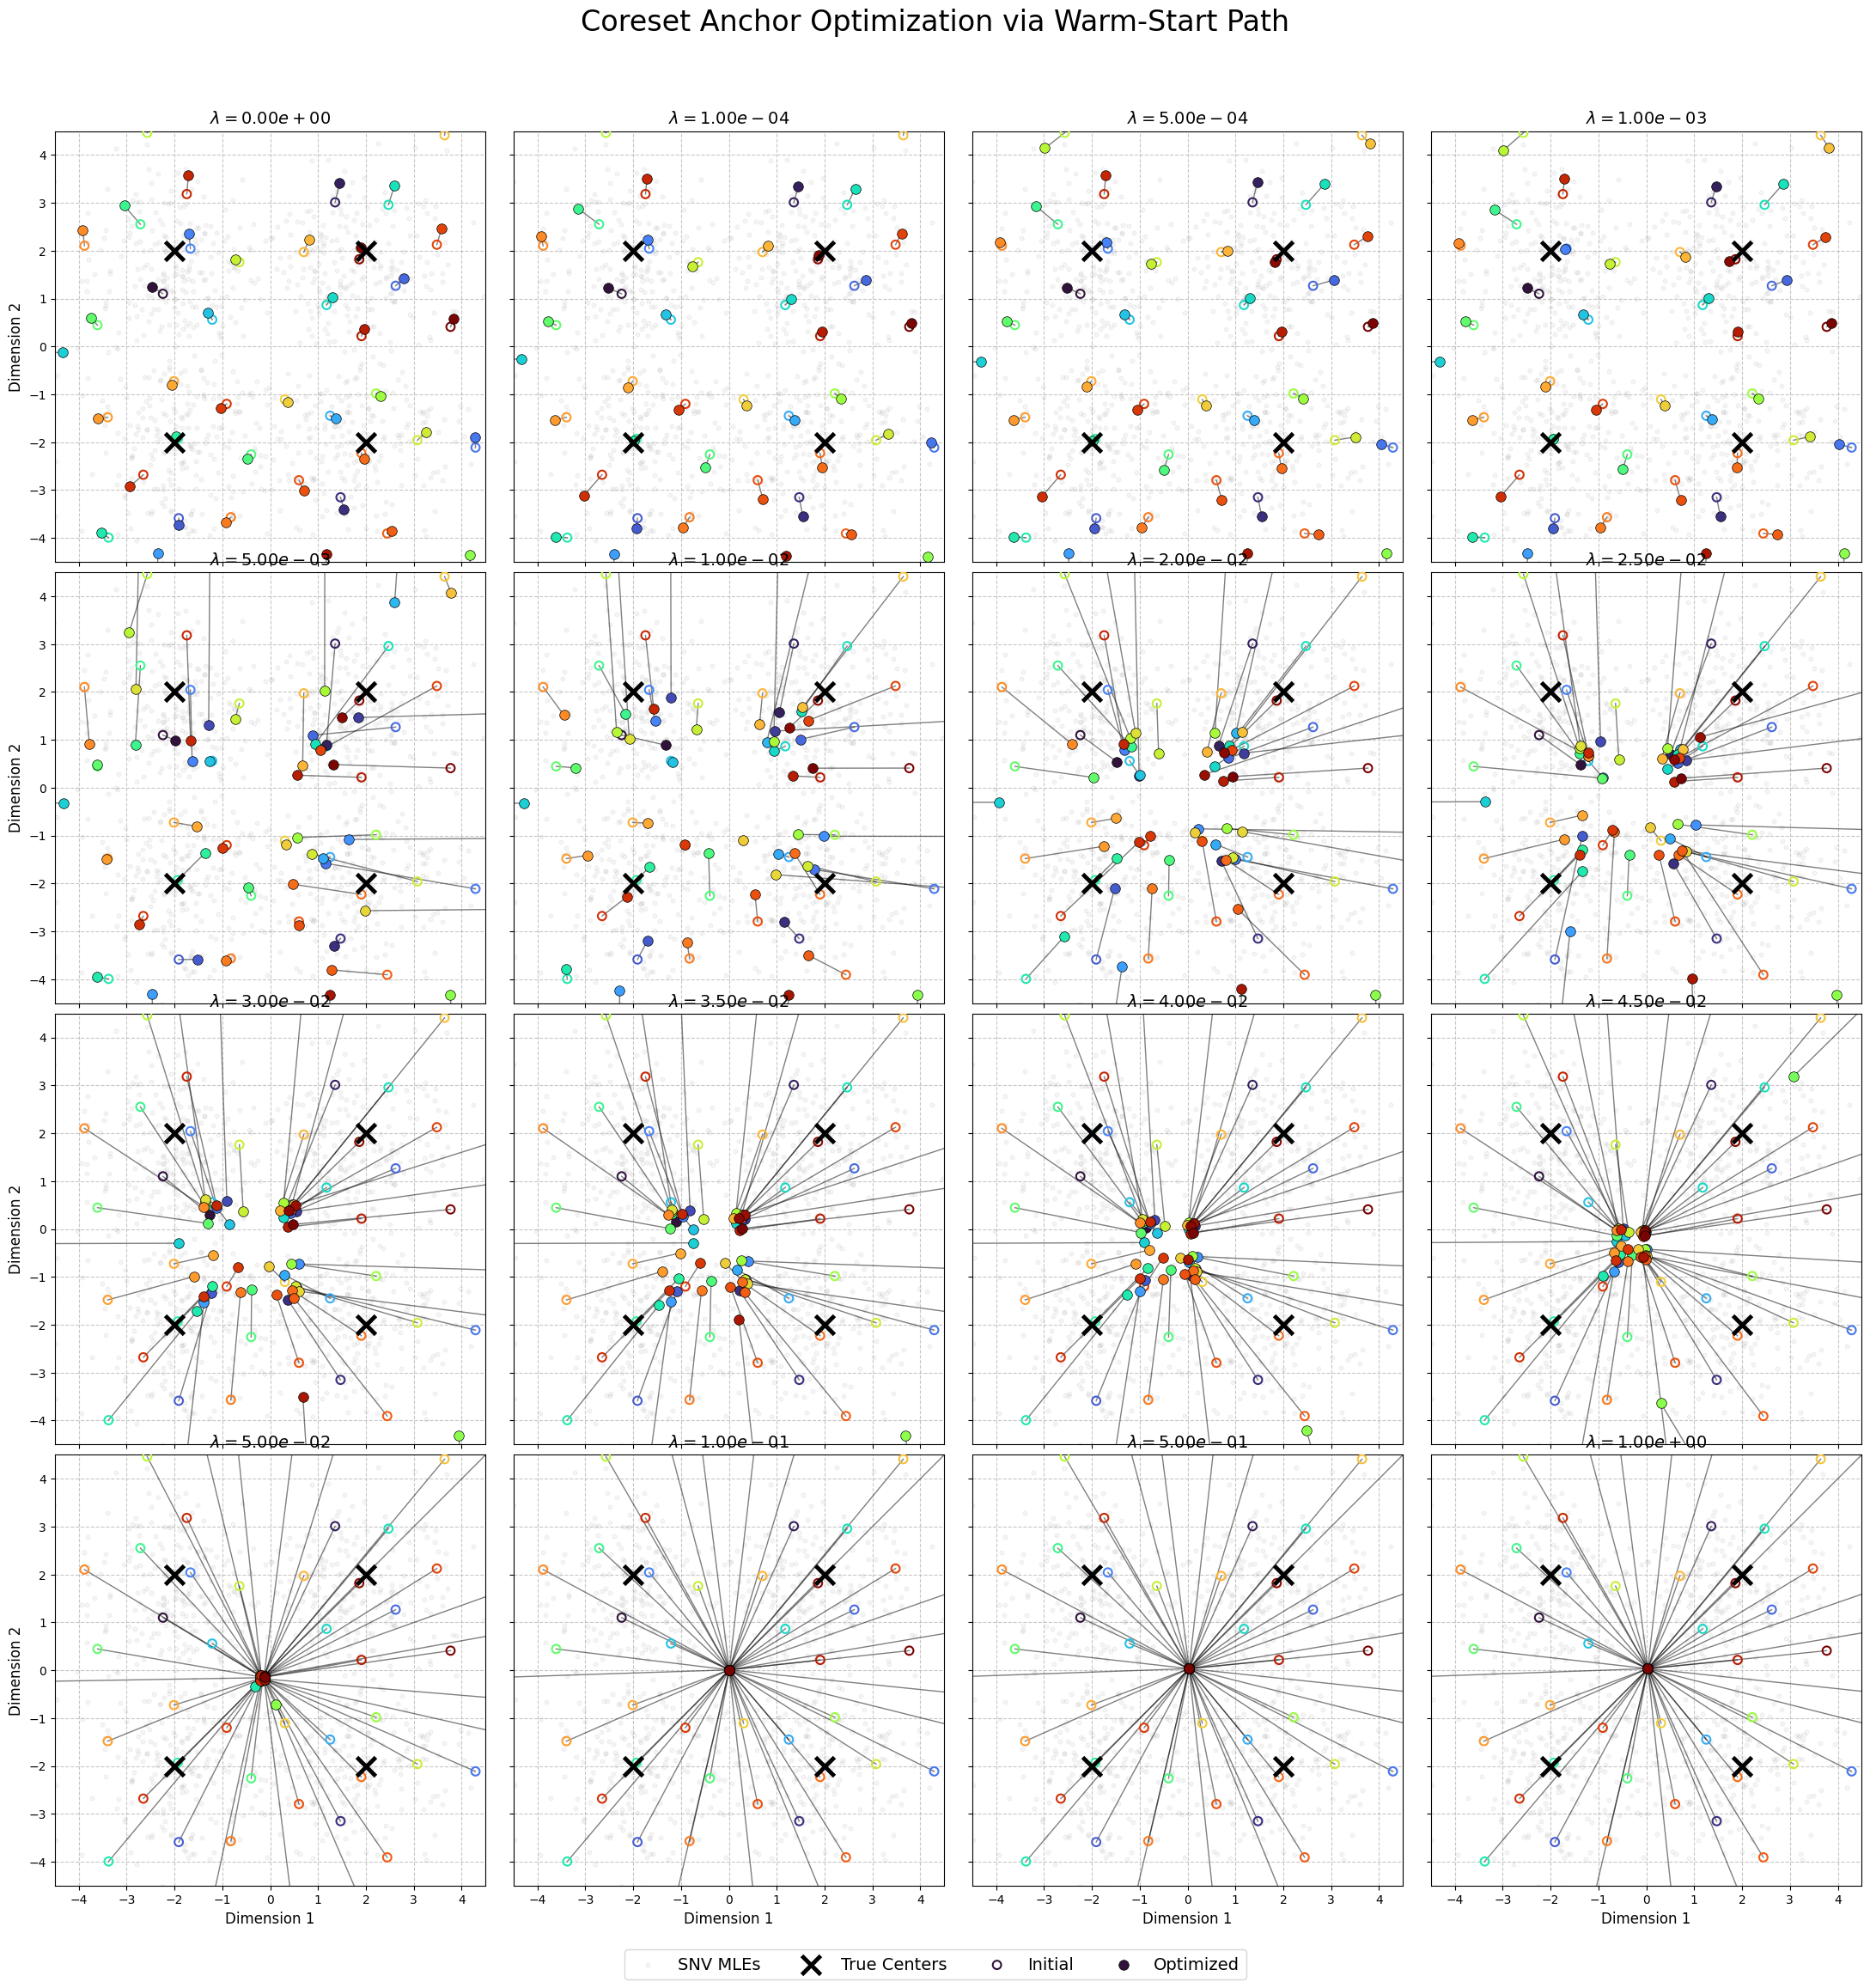

In [7]:
import torch
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import warnings
from scipy.special import expit, logit

# Import the public API from your framework module
# ASSUMPTION: Your framework code is saved as 'admm_framework.py'
from codebase.clipp2 import ADMMConfig, solve_coreset_path, validate_inputs

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module='matplotlib')


# ===================================================================
# SECTION 1: DATA GENERATION & PREPARATION (Corrected)
# ===================================================================

def generate_synthetic_data(n_clusters, snvs_per_cluster, M, noise_std=0.3):
    """Generates synthetic data for the simulation."""
    print("1. Generating synthetic data...")
    if n_clusters != 4 or M != 2:
        raise ValueError("This simulation is configured for n_clusters=4 and M=2.")
    true_centers = np.array([[2, 2], [-2, 2], [-2, -2], [2, -2]], dtype=np.float32)
    
    S = n_clusters * snvs_per_cluster
    np.random.seed(42)
    
    w_true = np.repeat(true_centers, snvs_per_cluster, axis=0)
    w_true += np.random.normal(0, noise_std, size=(S, M)).astype(np.float32)
    
    purity = np.full((S, M), 0.8, dtype=np.float32)
    minor = np.ones((S, M), dtype=np.float32)
    total = np.full((S, M), 2.0, dtype=np.float32)
    
    phi_true = expit(w_true)
    theta_true = np.clip(phi_true * minor / (2 * (1 - purity) + purity * total), 1e-9, 1 - 1e-9)
    
    n = np.random.poisson(200, size=(S, M)).astype(np.float32)
    r = np.random.binomial(n.astype(int), theta_true).astype(np.float32)
    
    print(f"   -> Generated {S} SNVs across {n_clusters} true clusters.")
    return {'r': r, 'n': n, 'minor': minor, 'total': total, 'purity': purity}, true_centers

def prepare_init_data(raw_data: dict, K: int, device: str) -> dict:
    """
    Prepares the 'init_data' dictionary.
    CORRECTED: Ensures all created tensors are torch.float32.
    """
    print("2. Preparing initial data dictionary for the solver...")
    
    r, n, p, t, m = raw_data['r'], raw_data['n'], raw_data['purity'], raw_data['total'], raw_data['minor']
    
    obs_vaf = r / n.clip(min=1)
    adj_factor = (2.0 * (1 - p) + p * t)
    num = obs_vaf * adj_factor
    p_hat_mle_np = np.log(num / (m - num).clip(min=1e-9)).clip(-10, 10)

    kmeans = KMeans(n_clusters=K, random_state=42, n_init='auto')
    cluster_assign_np = kmeans.fit_predict(p_hat_mle_np).astype(np.int64)
    w_init_np = kmeans.cluster_centers_

    S, M = r.shape
    w_pts = np.array([-4.0, -1.8, 1.8, 4.0], dtype=np.float32)
    expw, onep = np.exp(w_pts), 1 + np.exp(w_pts)
    purity_val, total_val, minor_val = p[0, 0], t[0, 0], m[0, 0]
    theta_den = onep[:, None, None] * (2.0 * (1 - purity_val) + total_val * purity_val)
    act = (expw[:, None, None] * minor_val) / theta_den
    a1 = (act[1] - act[0]) / (w_pts[1] - w_pts[0]); b1 = act[0] - a1 * w_pts[0]
    a2 = (act[2] - act[1]) / (w_pts[2] - w_pts[1]); b2 = act[1] - a2 * w_pts[1]
    a3 = (act[3] - act[2]) / (w_pts[3] - w_pts[2]); b3 = act[2] - a3 * w_pts[2]
    # Ensure c_all_np is float32 from the start
    c_all_np = np.tile(np.stack([a1,b1,a2,b2,a3,b3], axis=-1), (S, 1, 1))
    c_all_np = np.repeat(c_all_np, M, axis=1)


    _, counts = np.unique(cluster_assign_np, return_counts=True)
    cluster_size_np = np.zeros(K, dtype=np.float32)
    cluster_size_np[np.unique(cluster_assign_np)] = counts
    
    # *** THE FIX: Explicitly set dtype=torch.float32 for all tensors ***
    init_data = {
        'r_t': torch.tensor(r, device=device, dtype=torch.float32),
        'n_t': torch.tensor(n, device=device, dtype=torch.float32),
        'purity_t': torch.tensor(p, device=device, dtype=torch.float32),
        'total_t': torch.tensor(t, device=device, dtype=torch.float32),
        'minor_t': torch.tensor(m, device=device, dtype=torch.float32),
        'p_hat_mle': torch.tensor(p_hat_mle_np, device=device, dtype=torch.float32),
        'c_all_t': torch.tensor(c_all_np, device=device, dtype=torch.float32),
        'w_init_t': torch.tensor(w_init_np, device=device, dtype=torch.float32),
    }
    
    cluster_data = {
        'cluster_assign': torch.tensor(cluster_assign_np, device=device, dtype=torch.long),
        'cluster_size': torch.tensor(cluster_size_np, device=device, dtype=torch.float32)
    }
    
    print("   -> Data preparation complete.")
    return init_data, cluster_data

# ===================================================================
# SECTION 2: VISUALIZATION (Unchanged)
# ===================================================================

import math

def plot_simulation_results(path_results: dict, init_data: dict, true_centers: np.ndarray):
    """
    Visualizes the results of the coreset path optimization.
    UPDATED: Arranges plots into a grid with 4 columns.
    """
    print("4. Plotting results...")
    lambda_values = list(path_results.keys())
    n_lambdas = len(lambda_values)
    
    # *** THE CHANGE: Calculate grid dimensions and set figure size ***
    n_cols = 4
    n_rows = math.ceil(n_lambdas / n_cols)
    fig_width = n_cols * 5.5  # 5.5 inches per plot
    fig_height = n_rows * 6 # 6 inches per plot
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height), sharex=True, sharey=True)
    # Flatten the axes array for easy iteration, handles case where n_lambdas is not a multiple of 4
    axes_flat = axes.flatten()

    w_mle_np = init_data['p_hat_mle'].cpu().numpy()
    initial_centroids = init_data['w_init_t'].cpu().numpy()
    n_anchors = initial_centroids.shape[0]
    colors = plt.cm.turbo(np.linspace(0, 1, n_anchors))

    for i, lam in enumerate(lambda_values):
        ax = axes_flat[i]
        final_anchors = path_results[lam]['w_final_t'].cpu().numpy()
        
        ax.scatter(w_mle_np[:, 0], w_mle_np[:, 1], c='gray', alpha=0.08, s=12, label='SNV MLEs', rasterized=True)
        ax.scatter(true_centers[:, 0], true_centers[:, 1], c='black', marker='x', s=250, linewidth=3.5, label='True Centers', zorder=5)
        
        for k in range(n_anchors):
            ax.plot([initial_centroids[k, 0], final_anchors[k, 0]], 
                    [initial_centroids[k, 1], final_anchors[k, 1]], 
                    color='black', alpha=0.5, linewidth=1.0, zorder=2)
            # Only add labels for the very first plot's legend
            ax.scatter(initial_centroids[k, 0], initial_centroids[k, 1], 
                       facecolors='none', edgecolors=colors[k], s=50, linewidth=1.5, 
                       label='Initial' if i == 0 and k == 0 else None, zorder=3)
            ax.scatter(final_anchors[k, 0], final_anchors[k, 1], 
                       c=[colors[k]], s=70, marker='o', edgecolors='black', linewidth=0.5,
                       label='Optimized' if i == 0 and k == 0 else None, zorder=4)

        ax.set_title(f"$\lambda = {lam:.2e}$", fontsize=14)
        ax.set_xlim(-4.5, 4.5); ax.set_ylim(-4.5, 4.5)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.set_aspect('equal', adjustable='box')
        
        # Set labels on the outer edge of the grid
        if i % n_cols == 0:
            ax.set_ylabel("Dimension 2", fontsize=12)
        if i >= (n_lambdas - n_cols):
            ax.set_xlabel("Dimension 1", fontsize=12)

    # Turn off any unused subplots at the end of the grid
    for j in range(i + 1, len(axes_flat)):
        axes_flat[j].axis('off')

    fig.suptitle("Coreset Anchor Optimization via Warm-Start Path", fontsize=24, y=0.98)
    handles, labels = axes_flat[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, 0.02), fontsize=14)
    plt.tight_layout(rect=[0, 0.05, 1, 0.95]) # Adjust rect to make space for legend and title
    plt.show()

# ===================================================================
# SECTION 3: MAIN SIMULATION SCRIPT (Unchanged)
# ===================================================================

if __name__ == '__main__':
    DATA_GEN_PARAMS = {'n_clusters': 4, 'snvs_per_cluster': 250, 'M': 2, 'noise_std': 1}
    K_coreset = 50
    lambda_sequence = [0.0, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 2e-2, 2.5e-2, 3e-2, 3.5e-2, 4e-2, 4.5e-2, 5e-2, 1e-1, 5e-1, 1.0]

    config = ADMMConfig(precision=1e-4, Run_limit=100)
    print(f"Using device: {config.device}")

    raw_data_np, true_centers_np = generate_synthetic_data(**DATA_GEN_PARAMS)
    init_data, cluster_data = prepare_init_data(raw_data_np, K_coreset, config.device)
    
    print("\n3. Calling `solve_coreset_path` API...")
    path_results = solve_coreset_path(
        init_data=init_data,
        cluster_assign=cluster_data['cluster_assign'],
        cluster_size=cluster_data['cluster_size'],
        lambda_sequence=lambda_sequence,
        config=config
    )
    
    plot_simulation_results(path_results, init_data, true_centers_np)

<>:125: SyntaxWarning: invalid escape sequence '\l'
<>:125: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_6902/2827310827.py:125: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title(f"$\lambda = {lam:.2e}$", fontsize=14)
/tmp/ipykernel_6902/2827310827.py:49: RuntimeWarning: divide by zero encountered in log
  p_hat_mle_np = np.log(num / (m - num).clip(min=1e-9)).clip(-10, 10)


Using device: cuda
1. Generating synthetic data...
   -> Generated 1000 SNVs across 4 true clusters.
2. Preparing initial data dictionary for the solver...
   -> Data preparation complete.

3.A. Calling `solve_coreset_path` for all lambdas...
Validating inputs...
Input validation successful.
--- Starting Warm-Start ADMM Path for 16 Lambda values ---

Processing Path (Step 1/16): Lambda = 0.00e+00
Setting up Coreset Problem...
  -> Entering generic ADMM core (Lambda=0.00e+00)...
  -> ADMM core finished after 1 iterations.

Processing Path (Step 2/16): Lambda = 1.00e-04
Setting up Coreset Problem...
  -> Entering generic ADMM core (Lambda=1.00e-04)...
  -> ADMM core finished after 1 iterations.

Processing Path (Step 3/16): Lambda = 5.00e-04
Setting up Coreset Problem...
  -> Entering generic ADMM core (Lambda=5.00e-04)...
    Iter: 20, Residual: 0.000317
  -> ADMM core finished after 24 iterations.

Processing Path (Step 4/16): Lambda = 1.00e-03
Setting up Coreset Problem...
  -> Enteri

/tmp/ipykernel_6902/2827310827.py:107: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plot_colors = plt.cm.get_cmap('viridis', len(true_centers))


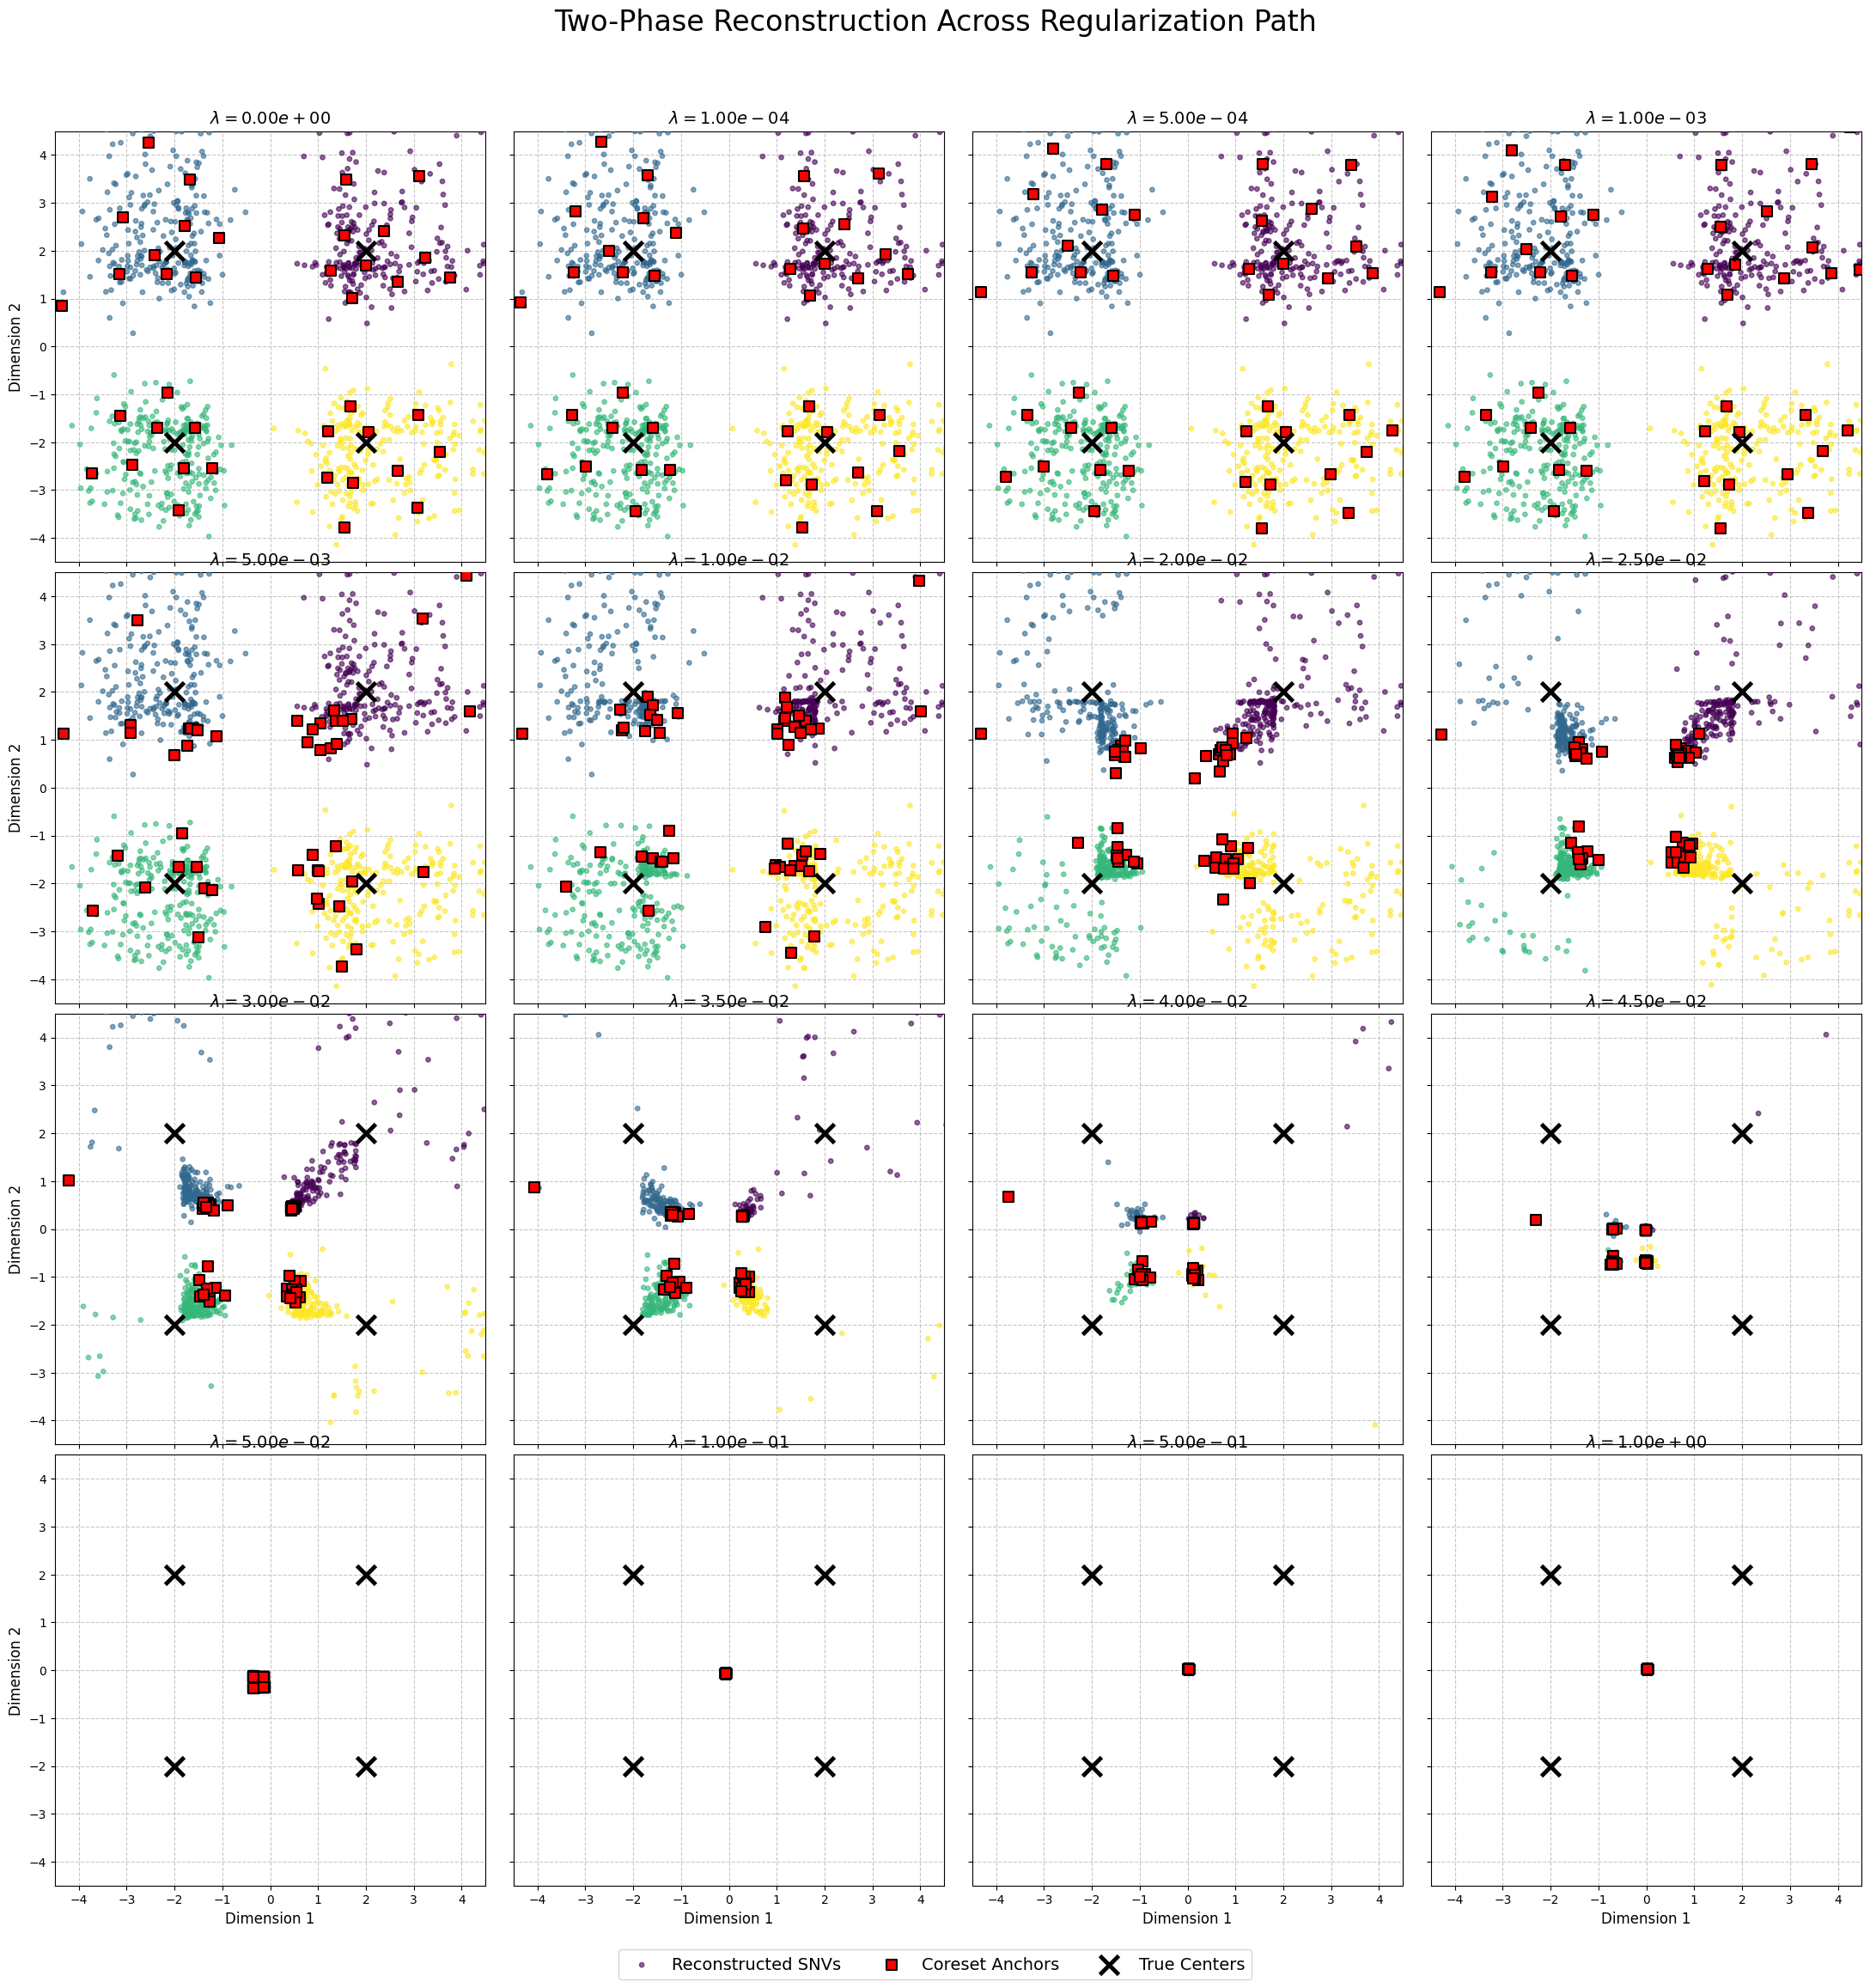

In [10]:
import torch
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import warnings
import math
from scipy.special import expit, logit

# Import the public API from your framework module
# ASSUMPTION: Your framework code is saved as 'admm_framework.py'
from codebase.clipp2 import ADMMConfig, solve_coreset_path, reconstruct_full_solution_admm

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module='matplotlib')


# ===================================================================
# SECTION 1: DATA GENERATION & PREPARATION
# ===================================================================

def generate_synthetic_data(n_clusters, snvs_per_cluster, M, noise_std=0.3):
    """Generates synthetic data for the simulation."""
    print("1. Generating synthetic data...")
    if n_clusters != 4 or M != 2:
        raise ValueError("This simulation is configured for n_clusters=4 and M=2.")
    true_centers = np.array([[2, 2], [-2, 2], [-2, -2], [2, -2]], dtype=np.float32)
    S = n_clusters * snvs_per_cluster
    np.random.seed(42)
    w_true = np.repeat(true_centers, snvs_per_cluster, axis=0) + np.random.normal(0, noise_std, size=(S, M)).astype(np.float32)
    purity = np.full((S, M), 0.8, dtype=np.float32)
    minor = np.ones((S, M), dtype=np.float32)
    total = np.full((S, M), 2.0, dtype=np.float32)
    phi_true = expit(w_true)
    theta_true = np.clip(phi_true * minor / (2 * (1 - purity) + purity * total), 1e-9, 1 - 1e-9)
    n = np.random.poisson(200, size=(S, M)).astype(np.float32)
    r = np.random.binomial(n.astype(int), theta_true).astype(np.float32)
    true_labels = np.repeat(np.arange(n_clusters), snvs_per_cluster)
    print(f"   -> Generated {S} SNVs across {n_clusters} true clusters.")
    return {'r': r, 'n': n, 'minor': minor, 'total': total, 'purity': purity}, true_centers, true_labels

def prepare_init_data(raw_data: dict, K: int, device: str) -> dict:
    """Prepares the 'init_data' dictionary required by the framework's public API."""
    print("2. Preparing initial data dictionary for the solver...")
    r, n, p, t, m = raw_data['r'], raw_data['n'], raw_data['purity'], raw_data['total'], raw_data['minor']
    obs_vaf = r / n.clip(min=1)
    adj_factor = (2.0 * (1 - p) + p * t)
    num = obs_vaf * adj_factor
    p_hat_mle_np = np.log(num / (m - num).clip(min=1e-9)).clip(-10, 10)

    kmeans = KMeans(n_clusters=K, random_state=42, n_init='auto')
    cluster_assign_np = kmeans.fit_predict(p_hat_mle_np).astype(np.int64)
    w_init_np = kmeans.cluster_centers_

    S, M = r.shape
    w_pts = np.array([-4.0, -1.8, 1.8, 4.0], dtype=np.float32)
    expw, onep = np.exp(w_pts), 1 + np.exp(w_pts)
    purity_val, total_val, minor_val = p[0, 0], t[0, 0], m[0, 0]
    theta_den = onep[:, None, None] * (2.0 * (1 - purity_val) + total_val * purity_val)
    act = (expw[:, None, None] * minor_val) / theta_den
    a1 = (act[1] - act[0]) / (w_pts[1] - w_pts[0]); b1 = act[0] - a1 * w_pts[0]
    a2 = (act[2] - act[1]) / (w_pts[2] - w_pts[1]); b2 = act[1] - a2 * w_pts[1]
    a3 = (act[3] - act[2]) / (w_pts[3] - w_pts[2]); b3 = act[2] - a3 * w_pts[2]
    c_all_np = np.tile(np.stack([a1,b1,a2,b2,a3,b3], axis=-1), (S, 1, 1))
    c_all_np = np.repeat(c_all_np, M, axis=1)

    _, counts = np.unique(cluster_assign_np, return_counts=True)
    cluster_size_np = np.zeros(K, dtype=np.float32)
    cluster_size_np[np.unique(cluster_assign_np)] = counts
    
    init_data = {
        'r_t': torch.tensor(r, device=device, dtype=torch.float32),
        'n_t': torch.tensor(n, device=device, dtype=torch.float32),
        'purity_t': torch.tensor(p, device=device, dtype=torch.float32),
        'total_t': torch.tensor(t, device=device, dtype=torch.float32),
        'minor_t': torch.tensor(m, device=device, dtype=torch.float32),
        'p_hat_mle': torch.tensor(p_hat_mle_np, device=device, dtype=torch.float32),
        'c_all_t': torch.tensor(c_all_np, device=device, dtype=torch.float32),
        'w_init_t': torch.tensor(w_init_np, device=device, dtype=torch.float32),
    }
    cluster_data = {
        'cluster_assign': torch.tensor(cluster_assign_np, device=device, dtype=torch.long),
        'cluster_size': torch.tensor(cluster_size_np, device=device, dtype=torch.float32)
    }
    print("   -> Data preparation complete.")
    return init_data, cluster_data

# ===================================================================
# SECTION 2: VISUALIZATION
# ===================================================================

def plot_reconstruction_path(reconstruction_path: dict, init_data: dict, true_centers: np.ndarray, true_labels: np.ndarray):
    """Visualizes the full two-phase reconstruction across the lambda path."""
    print("4. Plotting full reconstruction path...")
    lambda_values = list(reconstruction_path.keys())
    n_lambdas = len(lambda_values)
    
    n_cols = 4
    n_rows = math.ceil(n_lambdas / n_cols)
    fig_width = n_cols * 5.5
    fig_height = n_rows * 6
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height), sharex=True, sharey=True)
    axes_flat = axes.flatten()

    w_mle_np = init_data['p_hat_mle'].cpu().numpy()
    plot_colors = plt.cm.get_cmap('viridis', len(true_centers))

    for i, lam in enumerate(lambda_values):
        ax = axes_flat[i]
        result = reconstruction_path[lam]
        p_recon_np = result['p_recon_np']
        anchors_np = result['anchors_np']
        
        # Plot the final reconstructed positions, colored by their true cluster
        ax.scatter(p_recon_np[:, 0], p_recon_np[:, 1], c=true_labels, cmap=plot_colors, s=15, alpha=0.6, label='Reconstructed SNVs', zorder=3, rasterized=True)
        
        # Overlay the anchors that guided this reconstruction
        ax.scatter(anchors_np[:, 0], anchors_np[:, 1], 
                   c='red', marker='s', s=80, edgecolors='black', linewidth=1.5,
                   label='Coreset Anchors', zorder=4)

        ax.scatter(true_centers[:, 0], true_centers[:, 1], c='black', marker='x', s=250, linewidth=3.5, label='True Centers', zorder=5)

        ax.set_title(f"$\lambda = {lam:.2e}$", fontsize=14)
        ax.set_xlim(-4.5, 4.5); ax.set_ylim(-4.5, 4.5)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.set_aspect('equal', adjustable='box')
        
        if i % n_cols == 0: ax.set_ylabel("Dimension 2", fontsize=12)
        if i >= n_lambdas - n_cols: ax.set_xlabel("Dimension 1", fontsize=12)

    for j in range(i + 1, len(axes_flat)):
        axes_flat[j].axis('off')

    fig.suptitle("Two-Phase Reconstruction Across Regularization Path", fontsize=24, y=0.98)
    handles, labels = axes_flat[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, 0.02), fontsize=14)
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()

# ===================================================================
# SECTION 3: MAIN SIMULATION SCRIPT
# ===================================================================

if __name__ == '__main__':
    # --- Simulation Parameters ---
    DATA_GEN_PARAMS = {'n_clusters': 4, 'snvs_per_cluster': 250, 'M': 2, 'noise_std': 0.5}
    K_coreset = 50
    # Use the full lambda sequence as requested
    lambda_sequence = [0.0, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 2e-2, 2.5e-2, 3e-2, 3.5e-2, 4e-2, 4.5e-2, 5e-2, 1e-1, 5e-1, 1.0]

    # --- Setup ADMM Configuration ---
    config = ADMMConfig(precision=1e-4, Run_limit=150)
    print(f"Using device: {config.device}")

    # --- Generate and Prepare Data ---
    raw_data_np, true_centers_np, true_labels_np = generate_synthetic_data(**DATA_GEN_PARAMS)
    init_data, cluster_data = prepare_init_data(raw_data_np, K_coreset, config.device)
    
    # --- PHASE 1: Solve for Coreset Anchors across the entire path ---
    print("\n3.A. Calling `solve_coreset_path` for all lambdas...")
    coreset_path_results = solve_coreset_path(
        init_data=init_data,
        cluster_assign=cluster_data['cluster_assign'],
        cluster_size=cluster_data['cluster_size'],
        lambda_sequence=lambda_sequence,
        config=config
    )
    print("    -> Phase 1 (Coreset Optimization) Complete for all lambdas.")

    # --- PHASE 2: Reconstruct Full Solution for each result from Phase 1 ---
    print("\n3.B. Starting Phase 2 reconstruction for each lambda...")
    full_reconstruction_path = {}
    for lam, coreset_results in coreset_path_results.items():
        print(f"    -> Reconstructing for Lambda = {lam:.2e}")
        # Create a config specific to this lambda for the reconstruction phase
        recon_config = ADMMConfig(precision=1e-4, Run_limit=100, Lambda=lam)
        
        reconstruction_results = reconstruct_full_solution_admm(
            coreset_results=coreset_results,
            init_data=init_data,
            config=recon_config,
            cluster_size=cluster_data['cluster_size']
        )
        
        # Store results for plotting
        full_reconstruction_path[lam] = {
            'p_recon_np': reconstruction_results['p_recon_t'].cpu().numpy(),
            'anchors_np': coreset_results['w_final_t'].cpu().numpy()
        }

    # --- Visualize the final, reconstructed solutions for the entire path ---
    plot_reconstruction_path(
        reconstruction_path=full_reconstruction_path,
        init_data=init_data,
        true_centers=true_centers_np,
        true_labels=true_labels_np
    )

<>:109: SyntaxWarning: invalid escape sequence '\l'
<>:109: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_8288/2136700968.py:109: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title(f"$\lambda = {lam:.2e}$\nARI = {ari:.4f}", fontsize=14)
/tmp/ipykernel_8288/2136700968.py:46: RuntimeWarning: divide by zero encountered in log
  p_hat_mle_np = np.log(num / (m - num).clip(min=1e-9)).clip(-10, 10)


Using device: cuda
1. Generating synthetic data...
   -> Generated 1000 SNVs across 4 true clusters.
2. Preparing initial data dictionary for the solver...
   -> Data preparation complete.

--- Starting Method 1: Two-Phase Coreset Framework Path ---
Validating inputs...
Input validation successful.
--- Starting Warm-Start ADMM Path for 13 Lambda values ---

Processing Path (Step 1/13): Lambda = 0.00e+00
Setting up Coreset Problem...
  -> Entering generic ADMM core (Lambda=0.00e+00)...
  -> ADMM core finished after 1 iterations.

Processing Path (Step 2/13): Lambda = 1.00e-04
Setting up Coreset Problem...
  -> Entering generic ADMM core (Lambda=1.00e-04)...
  -> ADMM core finished after 1 iterations.

Processing Path (Step 3/13): Lambda = 5.00e-04
Setting up Coreset Problem...
  -> Entering generic ADMM core (Lambda=5.00e-04)...
    Iter: 20, Residual: 0.000318
  -> ADMM core finished after 24 iterations.

Processing Path (Step 4/13): Lambda = 1.00e-03
Setting up Coreset Problem...
  ->

/tmp/ipykernel_8288/2136700968.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plot_colors = plt.cm.get_cmap('viridis', num_unique_labels) if num_unique_labels > 1 else plt.cm.get_cmap('viridis')


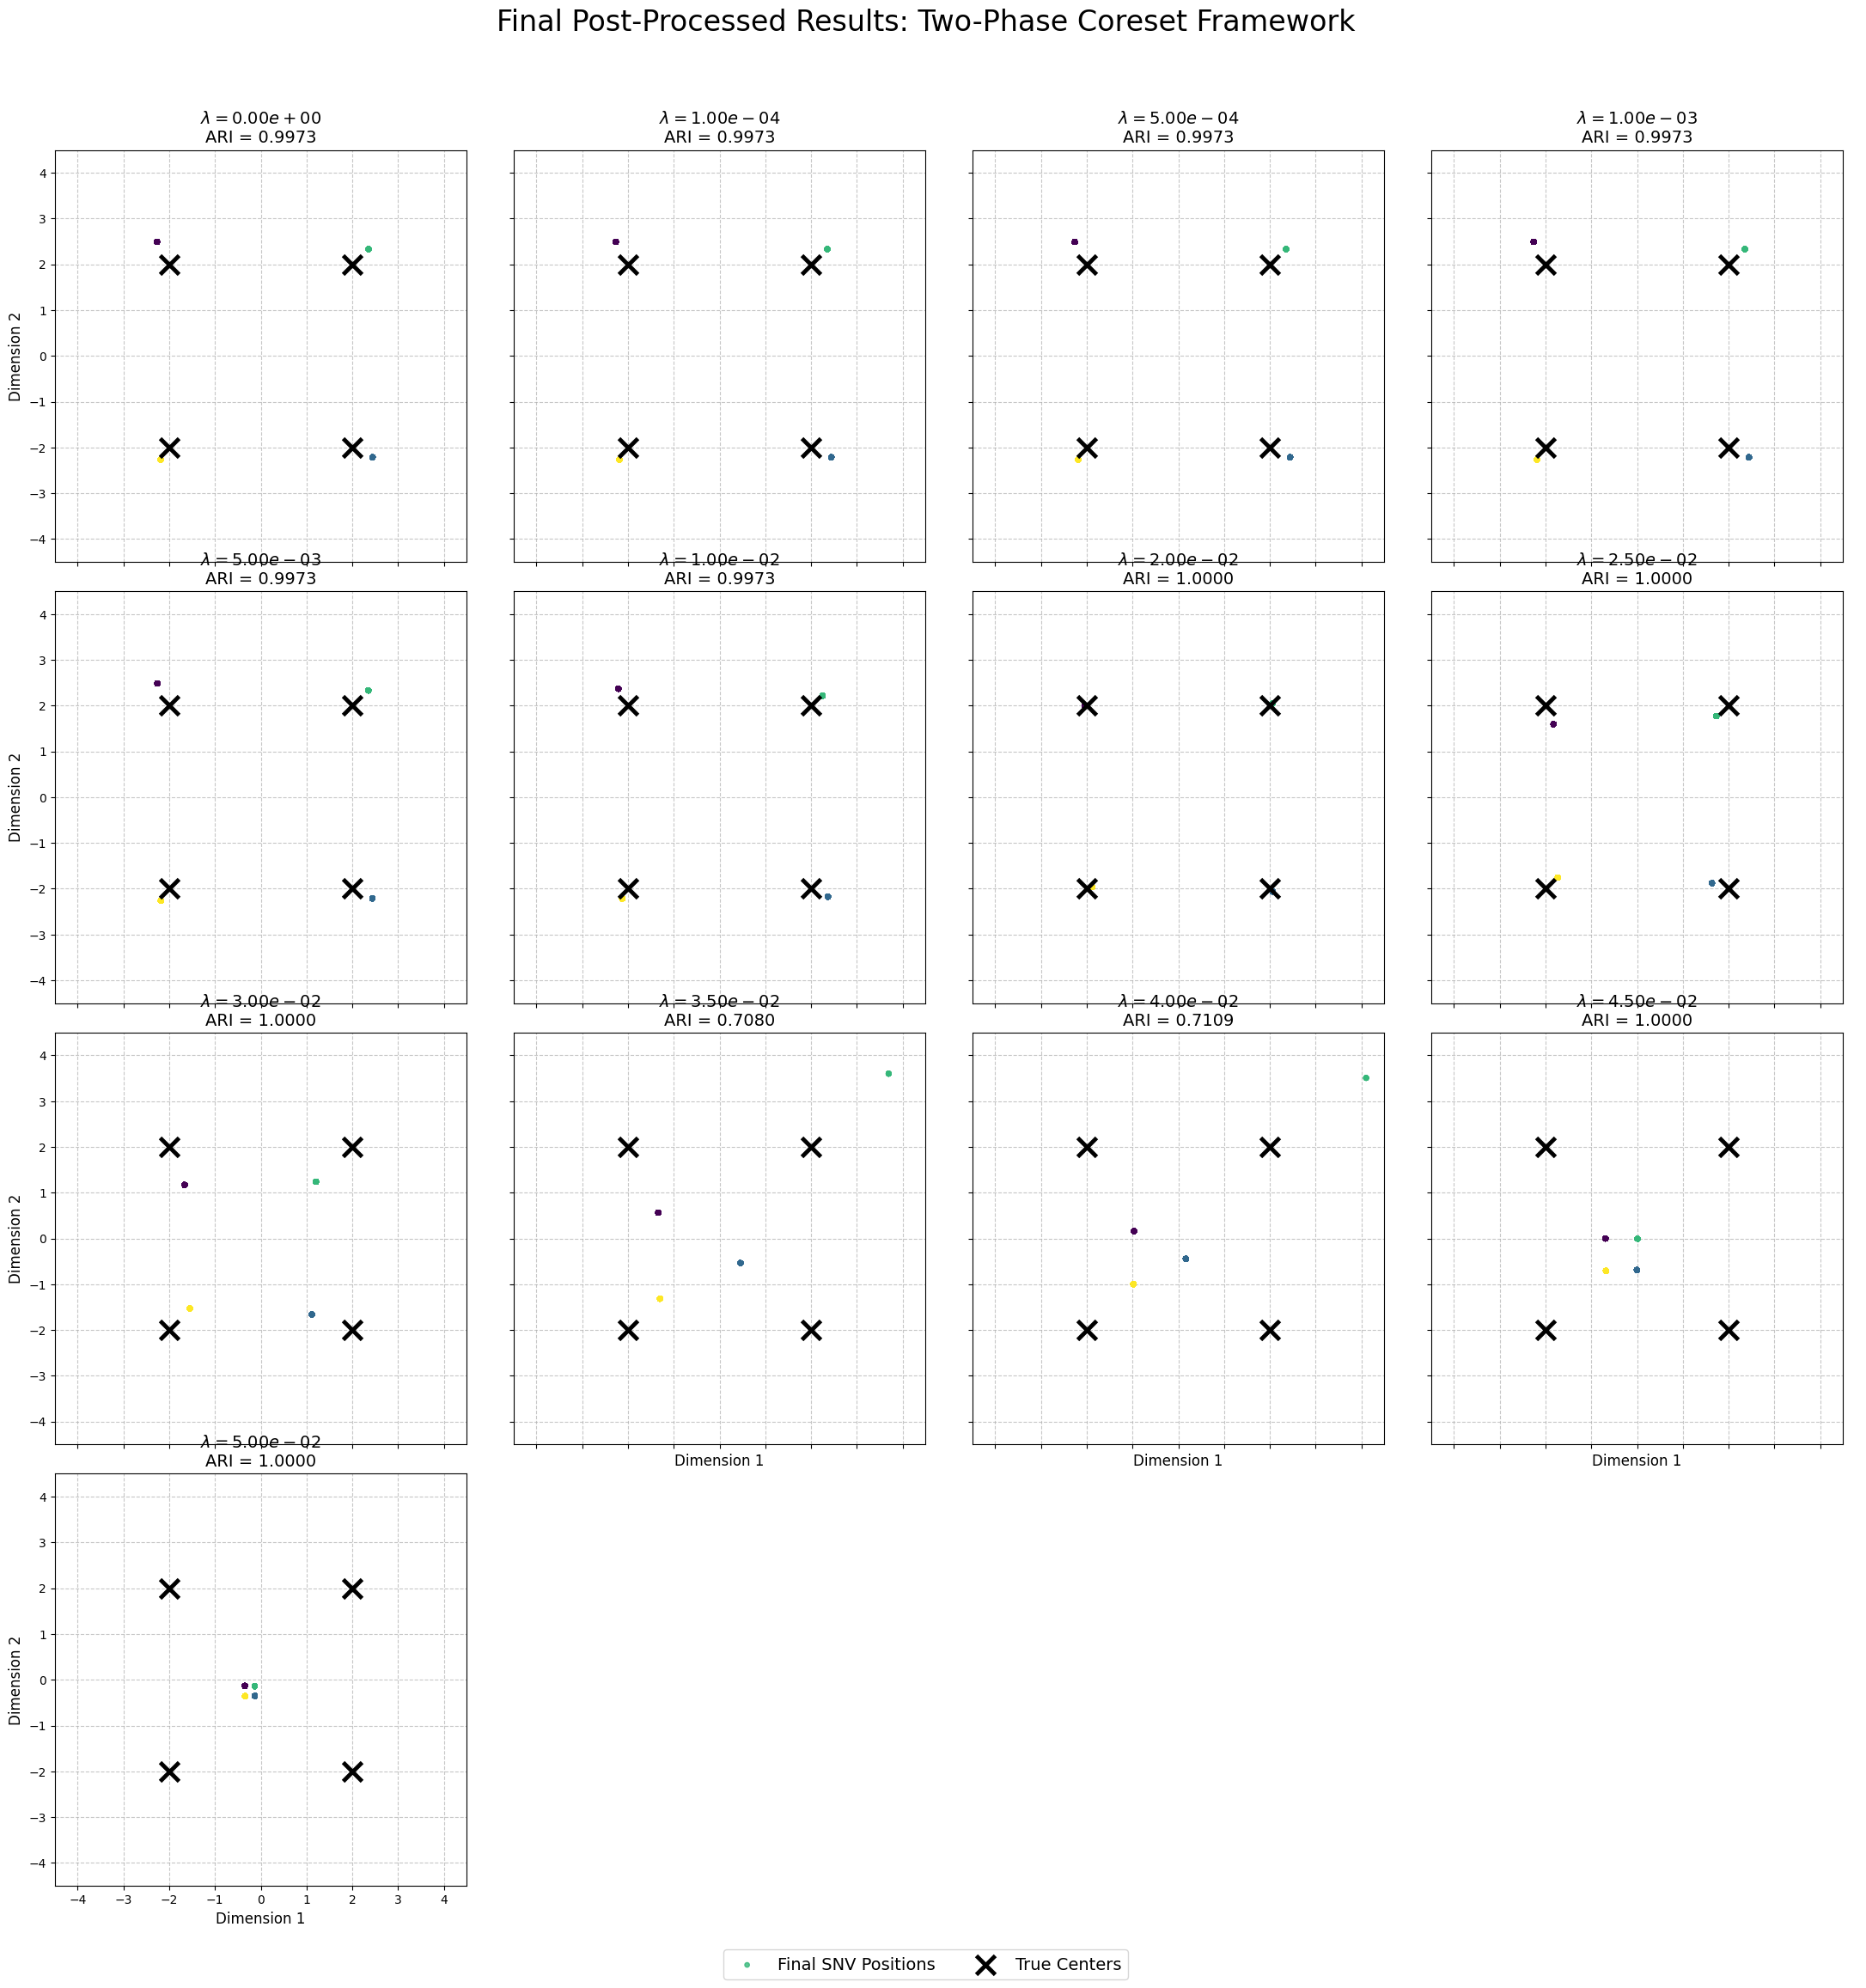

4. Plotting final results for Original Full Problem...


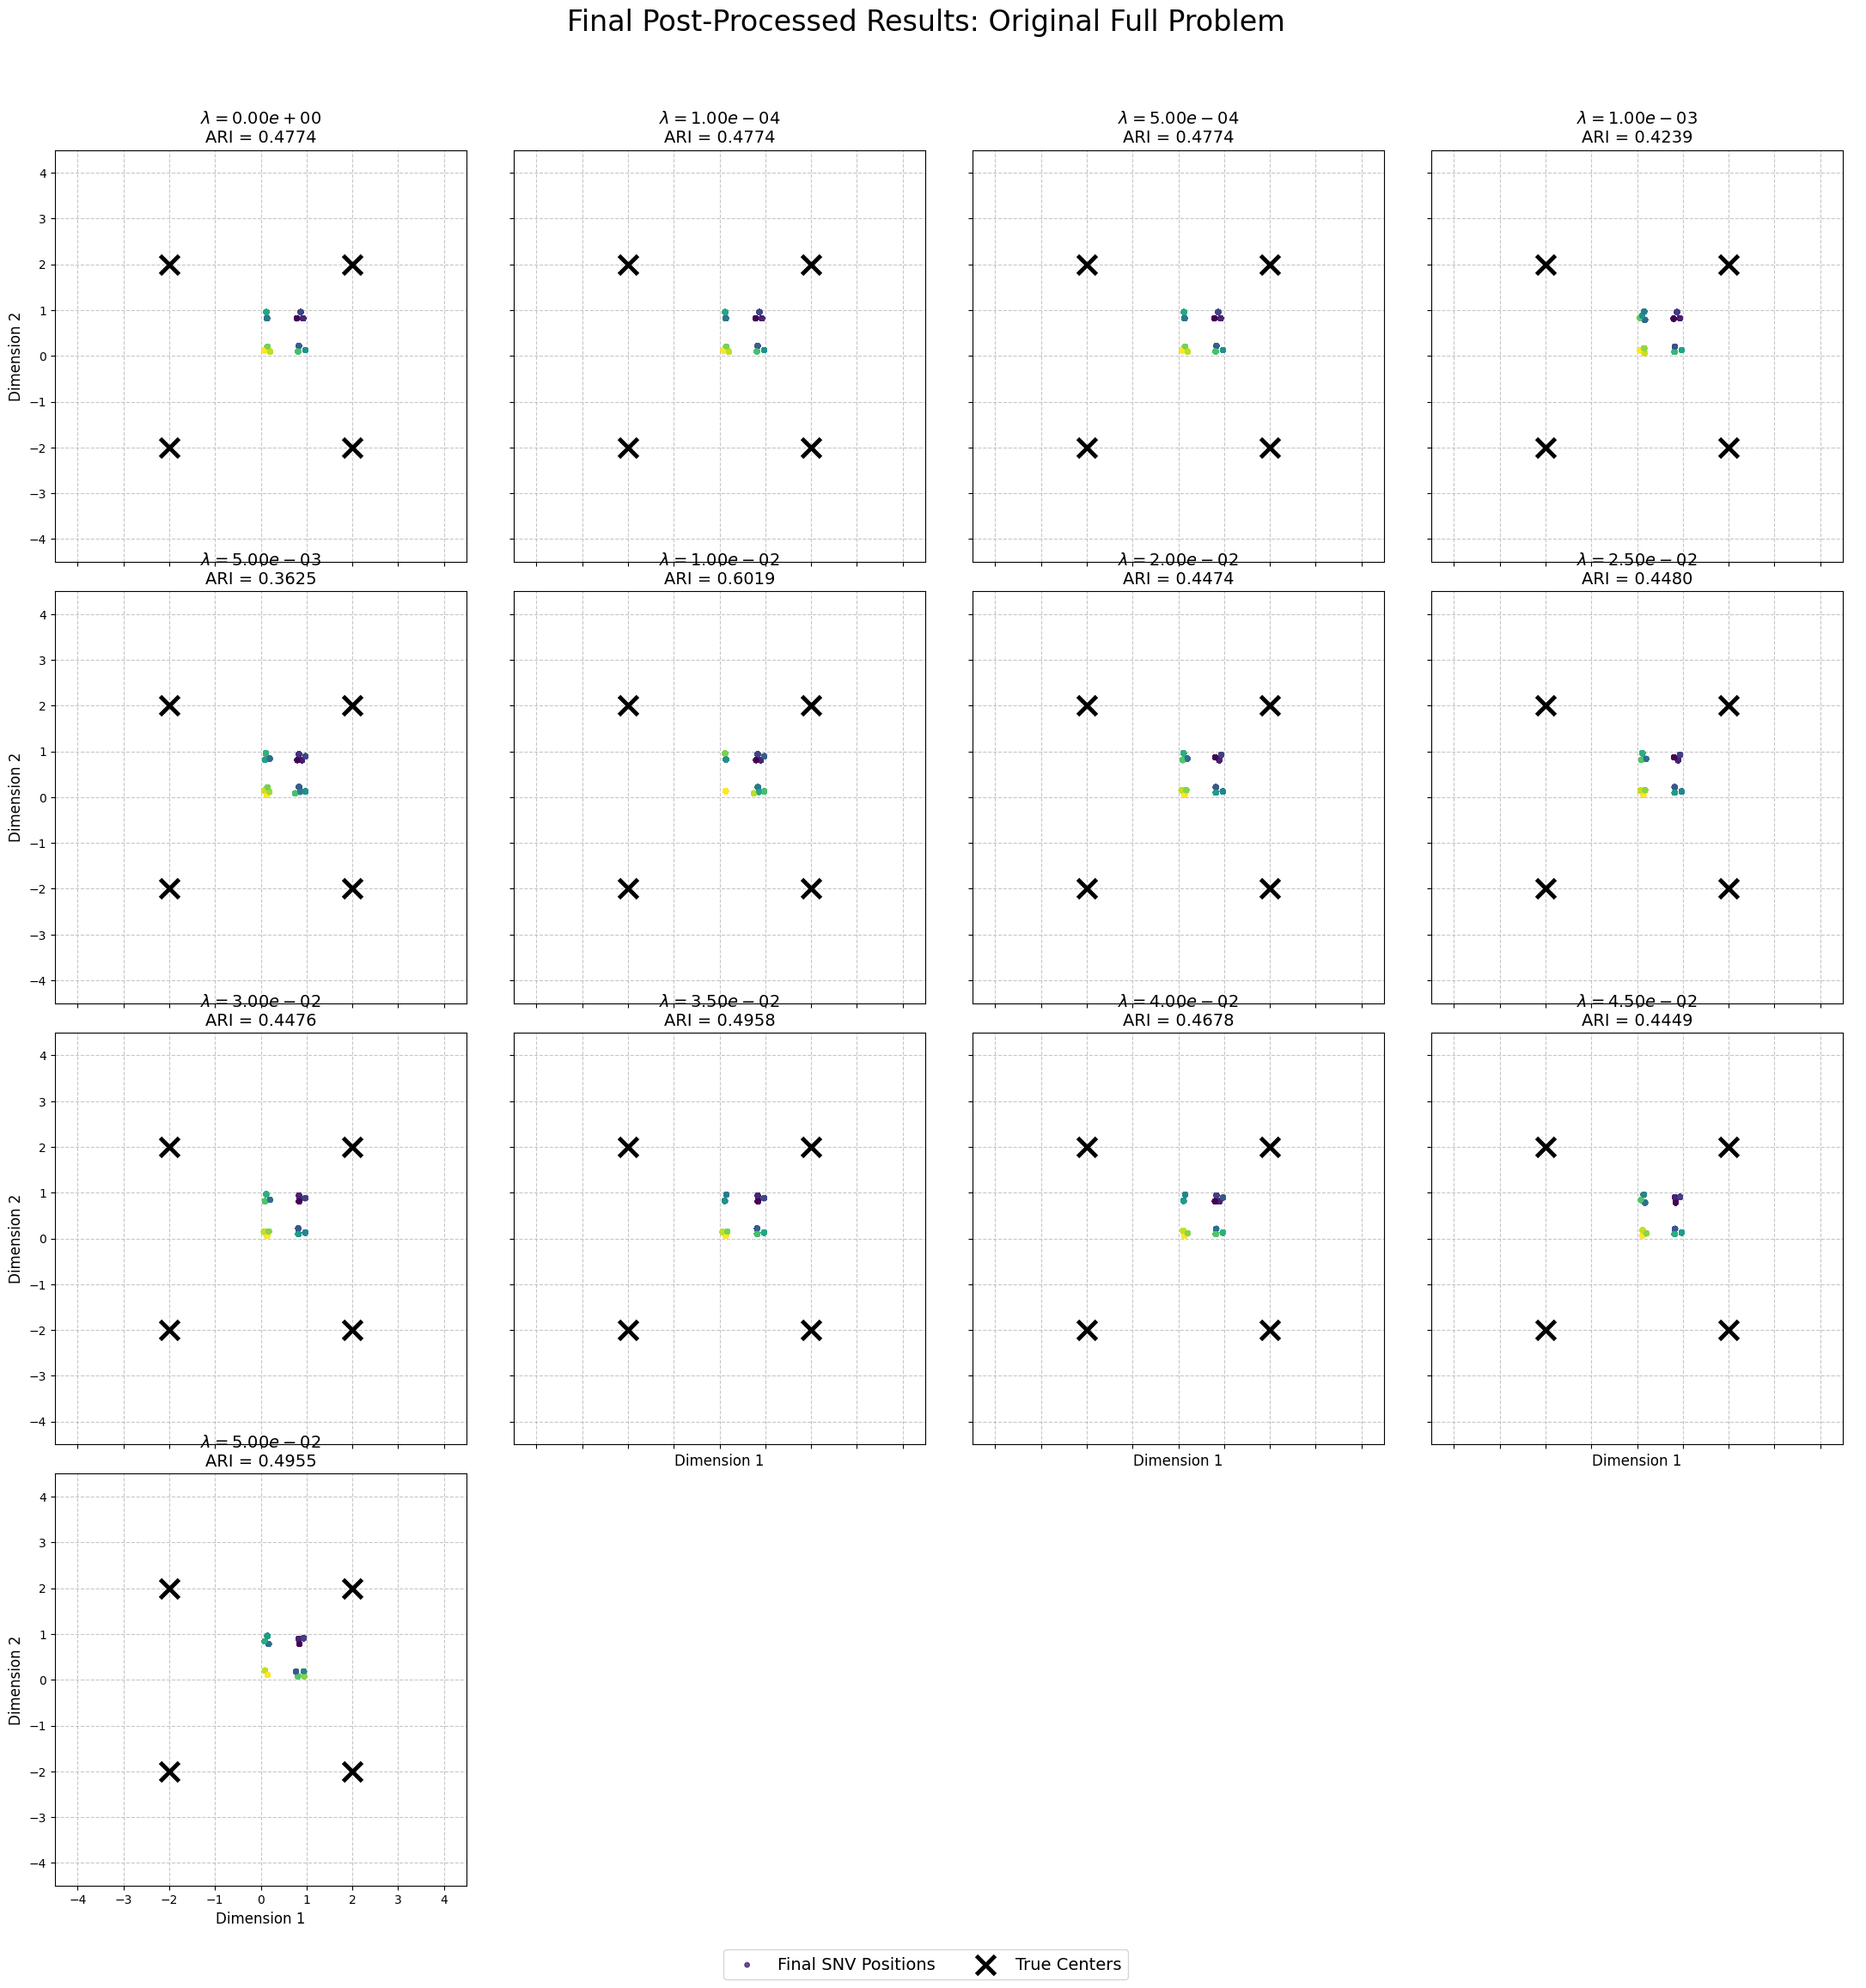

In [4]:
import torch
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import warnings
import math
from scipy.special import expit, logit
from sklearn.metrics import adjusted_rand_score

# Import the public API from your framework module
from codebase.clipp2 import ADMMConfig, solve_coreset_path, reconstruct_full_solution_admm, post_process_solution, solve_original_problem

# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module='matplotlib')


# ===================================================================
# SECTION 1: DATA GENERATION & PREPARATION (Unchanged)
# ===================================================================
def generate_synthetic_data(n_clusters, snvs_per_cluster, M, noise_std=0.3):
    print("1. Generating synthetic data...")
    if n_clusters != 4 or M != 2:
        raise ValueError("This simulation is configured for n_clusters=4 and M=2.")
    true_centers = np.array([[2, 2], [-2, 2], [-2, -2], [2, -2]], dtype=np.float32)
    S = n_clusters * snvs_per_cluster
    np.random.seed(42)
    w_true = np.repeat(true_centers, snvs_per_cluster, axis=0) + np.random.normal(0, noise_std, size=(S, M)).astype(np.float32)
    purity = np.full((S, M), 0.8, dtype=np.float32)
    minor = np.ones((S, M), dtype=np.float32)
    total = np.full((S, M), 2.0, dtype=np.float32)
    phi_true = expit(w_true)
    theta_true = np.clip(phi_true * minor / (2 * (1 - purity) + purity * total), 1e-9, 1 - 1e-9)
    n = np.random.poisson(200, size=(S, M)).astype(np.float32)
    r = np.random.binomial(n.astype(int), theta_true).astype(np.float32)
    true_labels = np.repeat(np.arange(n_clusters), snvs_per_cluster)
    print(f"   -> Generated {S} SNVs across {n_clusters} true clusters.")
    return {'r': r, 'n': n, 'minor': minor, 'total': total, 'purity': purity}, true_centers, true_labels

def prepare_init_data(raw_data: dict, K: int, device: str) -> dict:
    print("2. Preparing initial data dictionary for the solver...")
    r, n, p, t, m = raw_data['r'], raw_data['n'], raw_data['purity'], raw_data['total'], raw_data['minor']
    obs_vaf = r / n.clip(min=1)
    adj_factor = (2.0 * (1 - p) + p * t)
    num = obs_vaf * adj_factor
    p_hat_mle_np = np.log(num / (m - num).clip(min=1e-9)).clip(-10, 10)
    kmeans = KMeans(n_clusters=K, random_state=42, n_init='auto')
    cluster_assign_np = kmeans.fit_predict(p_hat_mle_np).astype(np.int64)
    w_init_np = kmeans.cluster_centers_
    S, M = r.shape
    w_pts = np.array([-4.0, -1.8, 1.8, 4.0], dtype=np.float32)
    expw, onep = np.exp(w_pts), 1 + np.exp(w_pts)
    purity_val, total_val, minor_val = p[0, 0], t[0, 0], m[0, 0]
    theta_den = onep[:, None, None] * (2.0 * (1 - purity_val) + total_val * purity_val)
    act = (expw[:, None, None] * minor_val) / theta_den
    a1 = (act[1] - act[0]) / (w_pts[1] - w_pts[0]); b1 = act[0] - a1 * w_pts[0]
    a2 = (act[2] - act[1]) / (w_pts[2] - w_pts[1]); b2 = act[1] - a2 * w_pts[1]
    a3 = (act[3] - act[2]) / (w_pts[3] - w_pts[2]); b3 = act[2] - a3 * w_pts[2]
    c_all_np = np.tile(np.stack([a1,b1,a2,b2,a3,b3], axis=-1), (S, 1, 1))
    c_all_np = np.repeat(c_all_np, M, axis=1)
    _, counts = np.unique(cluster_assign_np, return_counts=True)
    cluster_size_np = np.zeros(K, dtype=np.float32)
    cluster_size_np[np.unique(cluster_assign_np)] = counts
    init_data = {'r_t': torch.tensor(r, device=device, dtype=torch.float32),'n_t': torch.tensor(n, device=device, dtype=torch.float32),'purity_t': torch.tensor(p, device=device, dtype=torch.float32),'total_t': torch.tensor(t, device=device, dtype=torch.float32),'minor_t': torch.tensor(m, device=device, dtype=torch.float32),'p_hat_mle': torch.tensor(p_hat_mle_np, device=device, dtype=torch.float32),'c_all_t': torch.tensor(c_all_np, device=device, dtype=torch.float32),'w_init_t': torch.tensor(w_init_np, device=device, dtype=torch.float32),}
    cluster_data = {'cluster_assign': torch.tensor(cluster_assign_np, device=device, dtype=torch.long),'cluster_size': torch.tensor(cluster_size_np, device=device, dtype=torch.float32)}
    print("   -> Data preparation complete.")
    return init_data, cluster_data

# ===================================================================
# SECTION 2: VISUALIZATION (Unchanged)
# ===================================================================
def plot_final_results(final_results: dict, init_data: dict, true_centers: np.ndarray, method_name: str):
    """
    Visualizes the final post-processed results across the lambda path, including ARI scores.
    CORRECTED: Accepts the `method_name` argument.
    """
    print(f"4. Plotting final results for {method_name}...")
    lambda_values = list(final_results.keys())
    n_lambdas = len(lambda_values)
    
    n_cols = 4
    n_rows = math.ceil(n_lambdas / n_cols) if n_cols > 0 else 0
    if n_rows == 0:
        print("No results to plot.")
        return
        
    fig_width = n_cols * 5.5
    fig_height = n_rows * 6
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height), sharex=True, sharey=True, squeeze=False)
    axes_flat = axes.flatten()

    w_mle_np = init_data['p_hat_mle'].cpu().numpy()

    for i, lam in enumerate(lambda_values):
        ax = axes_flat[i]
        result = final_results[lam]
        phi_final_np = result['phi_final']
        labels = result['labels']
        ari = result['ari']
        
        # Handle cases where all points are in one cluster
        num_unique_labels = len(np.unique(labels))
        plot_colors = plt.cm.get_cmap('viridis', num_unique_labels) if num_unique_labels > 1 else plt.cm.get_cmap('viridis')

        ax.scatter(phi_final_np[:, 0], phi_final_np[:, 1], c=labels, cmap=plot_colors, s=15, alpha=0.8, label='Final SNV Positions', zorder=3, rasterized=True)
        ax.scatter(true_centers[:, 0], true_centers[:, 1], c='black', marker='x', s=250, linewidth=3.5, label='True Centers', zorder=5)

        ax.set_title(f"$\lambda = {lam:.2e}$\nARI = {ari:.4f}", fontsize=14)
        ax.set_xlim(-4.5, 4.5); ax.set_ylim(-4.5, 4.5)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.set_aspect('equal', adjustable='box')
        
        # Set labels on the outer edge of the grid
        if i % n_cols == 0:
            ax.set_ylabel("Dimension 2", fontsize=12)
        if i >= n_lambdas - n_cols:
            ax.set_xlabel("Dimension 1", fontsize=12)

    # Turn off any unused subplots at the end of the grid
    for j in range(i + 1, len(axes_flat)):
        axes_flat[j].axis('off')

    fig.suptitle(f"Final Post-Processed Results: {method_name}", fontsize=24, y=0.98)
    handles, labels_legend = axes_flat[0].get_legend_handles_labels()
    fig.legend(handles, labels_legend, loc='lower center', ncol=2, bbox_to_anchor=(0.5, 0.02 if n_rows > 1 else -0.05), fontsize=14)
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()

# ===================================================================
# SECTION 3: MAIN SIMULATION SCRIPT (Corrected)
# ===================================================================
if __name__ == '__main__':
    DATA_GEN_PARAMS = {'n_clusters': 4, 'snvs_per_cluster': 250, 'M': 2, 'noise_std': 0.5}
    K_coreset = 50
    lambda_sequence = [0.0, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 2e-2, 2.5e-2, 3e-2, 3.5e-2, 4e-2, 4.5e-2, 5e-2]
    config = ADMMConfig(precision=1e-4, Run_limit=200)
    print(f"Using device: {config.device}")

    raw_data_np, true_centers_np, true_labels_np = generate_synthetic_data(**DATA_GEN_PARAMS)
    init_data, cluster_data = prepare_init_data(raw_data_np, K_coreset, config.device)
    
    # --- METHOD 1: Run and Post-Process the full Two-Phase Coreset Framework ---
    print("\n--- Starting Method 1: Two-Phase Coreset Framework Path ---")
    coreset_path_results = solve_coreset_path(
        init_data=init_data, cluster_assign=cluster_data['cluster_assign'],
        cluster_size=cluster_data['cluster_size'], lambda_sequence=lambda_sequence, config=config
    )
    
    coreset_final_results = {}
    for lam, results in coreset_path_results.items():
        print(f"    -> Finalizing Coreset result for Lambda = {lam:.2e}")
        recon_config = ADMMConfig(precision=1e-4, Run_limit=150, Lambda=lam)
        recon_results = reconstruct_full_solution_admm(
            coreset_results=results, init_data=init_data,
            config=recon_config, cluster_size=cluster_data['cluster_size']
        )
        p_recon_np = recon_results['p_recon_t'].cpu().numpy()

        # *** THE FIX: Use KMeans for final clustering instead of incorrect post-processing ***
        n_true_clusters = DATA_GEN_PARAMS['n_clusters']
        final_kmeans = KMeans(n_clusters=n_true_clusters, random_state=42, n_init='auto')
        final_labels = final_kmeans.fit_predict(p_recon_np)
        
        # The final "phi" is just the reconstructed p for plotting purposes
        # A more rigorous approach would average the original phi_hats per cluster
        phi_final_np = np.zeros_like(p_recon_np)
        for label_val in range(n_true_clusters):
            mask = (final_labels == label_val)
            if np.any(mask):
                phi_final_np[mask] = p_recon_np[mask].mean(axis=0)

        ari = adjusted_rand_score(true_labels_np, final_labels)
        coreset_final_results[lam] = {'phi_final': phi_final_np, 'labels': final_labels, 'ari': ari}
        
    # --- METHOD 2: Run and Post-Process the Original Full Problem Solver ---
    print("\n--- Starting Method 2: Original Full Problem Path ---")
    original_final_results = {}
    raw_data_np_dict = {key: val.cpu().numpy() for key, val in init_data.items()}
    for lam in lambda_sequence:
        print(f"    -> Solving & Post-Processing Original Problem for Lambda = {lam:.2e}")
        orig_config = ADMMConfig(precision=1e-4, Run_limit=200, Lambda=lam)
        orig_results = solve_original_problem(init_data, orig_config)
        post_processed_orig = post_process_solution(
            p_final=orig_results['w_final_t'].cpu().numpy(),
            eta_final=orig_results['eta_final_t'].cpu().numpy(),
            raw_data_np=raw_data_np_dict,
            post_th=0.001, least_diff=0.1
        )
        post_processed_orig['ari'] = adjusted_rand_score(true_labels_np, post_processed_orig['labels'])
        original_final_results[lam] = post_processed_orig

    # --- Final Comparison Visualization ---
    plot_final_results(coreset_final_results, init_data, true_centers_np, "Two-Phase Coreset Framework")
    plot_final_results(original_final_results, init_data, true_centers_np, "Original Full Problem")